In [20]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
import py3Dmol
import random
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

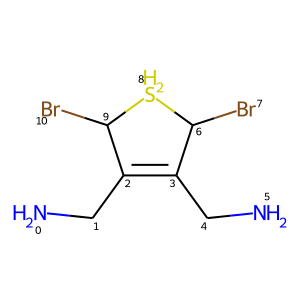

In [38]:
Chem.MolFromSmiles('NCC1=C(CN)C(Br)[SH2]C1Br')

In [33]:
file_name = '../data/ZINC_250k.smi'
mol_list=[]
with open(file_name,'r') as file:
    for i,smiles in enumerate(file):
        mol_list.append(Chem.MolFromSmiles(smiles))
        if i == 1000:
            break

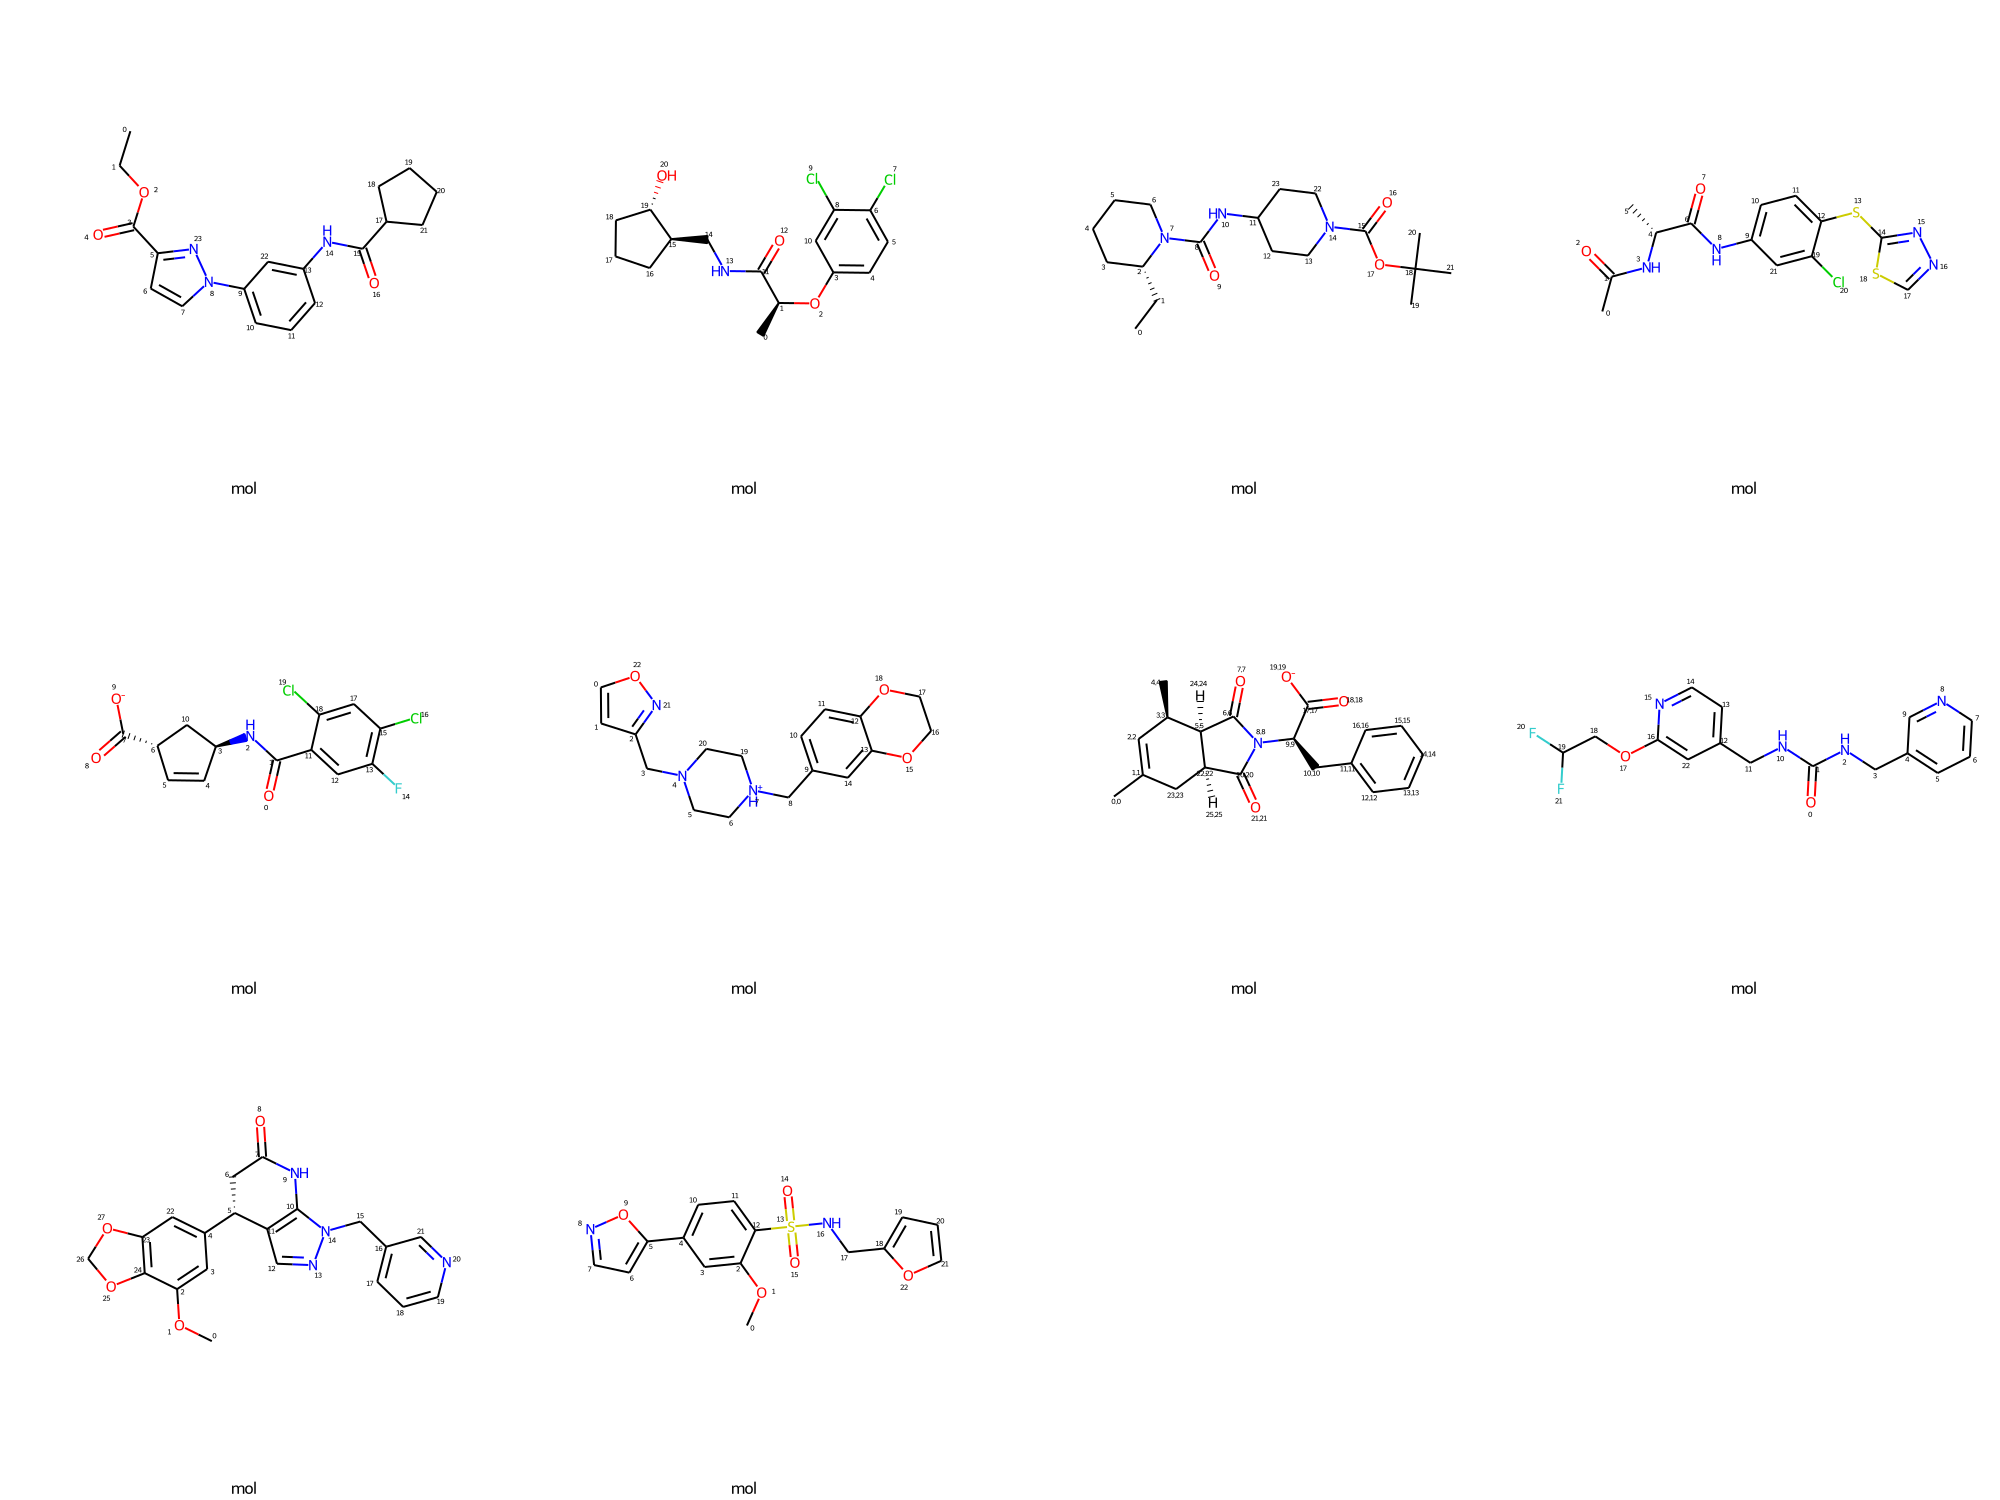

In [37]:
Draw.MolsToGridImage(random.sample(mol_list,10),molsPerRow=4,maxMols=10,legends=['mol' for x in range(100,120)], subImgSize=(500,500))

Doing 

###  Trying out mol simplify for putting ligands on core 

In [8]:
# Exmaple from mol simplify
propane_mol = mol3D()          # create a mol3D object
propane_mol.read_smiles('CCC') # read SMILES string into the mol3D object
print(propane_mol.writexyz('',writestring=True)) #
from molSimplify.Informatics.jupyter_vis import view_structures
view_structures([propane_mol])

NameError: name 'mol3D' is not defined

### Commandline commands

molsimplify -core mo -oxstate 3 -geometry tbp -lig "CC(C)(C)[N-]C1=CC(C)=CC(C)=C1", "N#N" -ligocc 3, 1 -ligloc True -keepHs True -skipANN True -ff MMFF94 -smicat [5], [1]

molsimplify -core mo -oxstate 3 -geometry tbp -lig "C[N-]CCN(CC[N-]C)CC[N-]C", "N#N" -ligocc 1, 1 -ligloc True -keepHs True -skipANN False -ff MMFF94 -smicat [8, 2, 12, 5], [1]


# Keywords explained: 
- core:
    -specify what metal atom to use as core to put   ligands on
- lig specifies the ligand to put on. And if more ligs
are provided, the order determines which ones are put on first. 
- ligocc specifies how many times the ligand occurs. 
- oxstate determines how many bonds the transition metal has. 
- smicat specifies what smiles atoms coordinate the metal.
- liglocc
One can have "-ligloc True" in the input file to make sure that the order of the input ligands is maintained in the octahedral structure generation, where ligands will be placed at the equatorial plane first then the axial plane.
- keep Hs: By default, one hydrogen atom (if present) is stripped from each coordinating atom (keepHs no). This is beneficial in most cases but should be disabled (keepHs yes) in some cases such as ammonia or ethylenediamine.
specifying the oxidation and spin state, which activates spin- and oxidation-state-dependent metal-ligand bond lengths that are generally of higher quality than the default sum of covalent radii
- ff:
optimization (off by default), which activates partial force field optimizations that significantly improve structures containing bulky ligands
- skipANN: 
Defines if ml model is loaded or not

In [9]:
from molSimplify.Classes.mol3D import mol3D

In [10]:
schrock_mol = mol3D()
mol = Chem.MolFromMolFile(
        "/home/magstr/Documents/nitrogenase/schrock/diagrams_schrock/dft/cycle_restart/Mo_N2/ams.results/traj.mol", sanitize = False, removeHs=False)
smiles = Chem.MolToSmiles(mol)


In [11]:
smiles

'[H]c1c(-c2c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c2C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c(N2C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])N(c4c([H])c(-c5c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c5C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c(-c5c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c5C([H])(C([H])([H])[H])C([H])([H])[H])c4[H])[Mo]2(N#N)N(c2c([H])c(-c4c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c4C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c(-c4c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c4C([H])(C([H])([H])[H])C([H])([H])[H])c2[H])C([H])([H])C3([H])[H])c([H])c1-c1c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1C([H])(C([H])([H])[H])C([H])([H])[H]'

In [14]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

### Test my own core as core in molsimplify

# Vizualizing smarts with rest api

In [15]:
import requests
import urllib
from IPython.display import Image
baseurl = "https://smarts.plus/smartsview/download_rest?"

In [16]:
def get_img(query):
    url = baseurl+query
    res = requests.get(url)
    return Image(res.content,width=500,height=500)

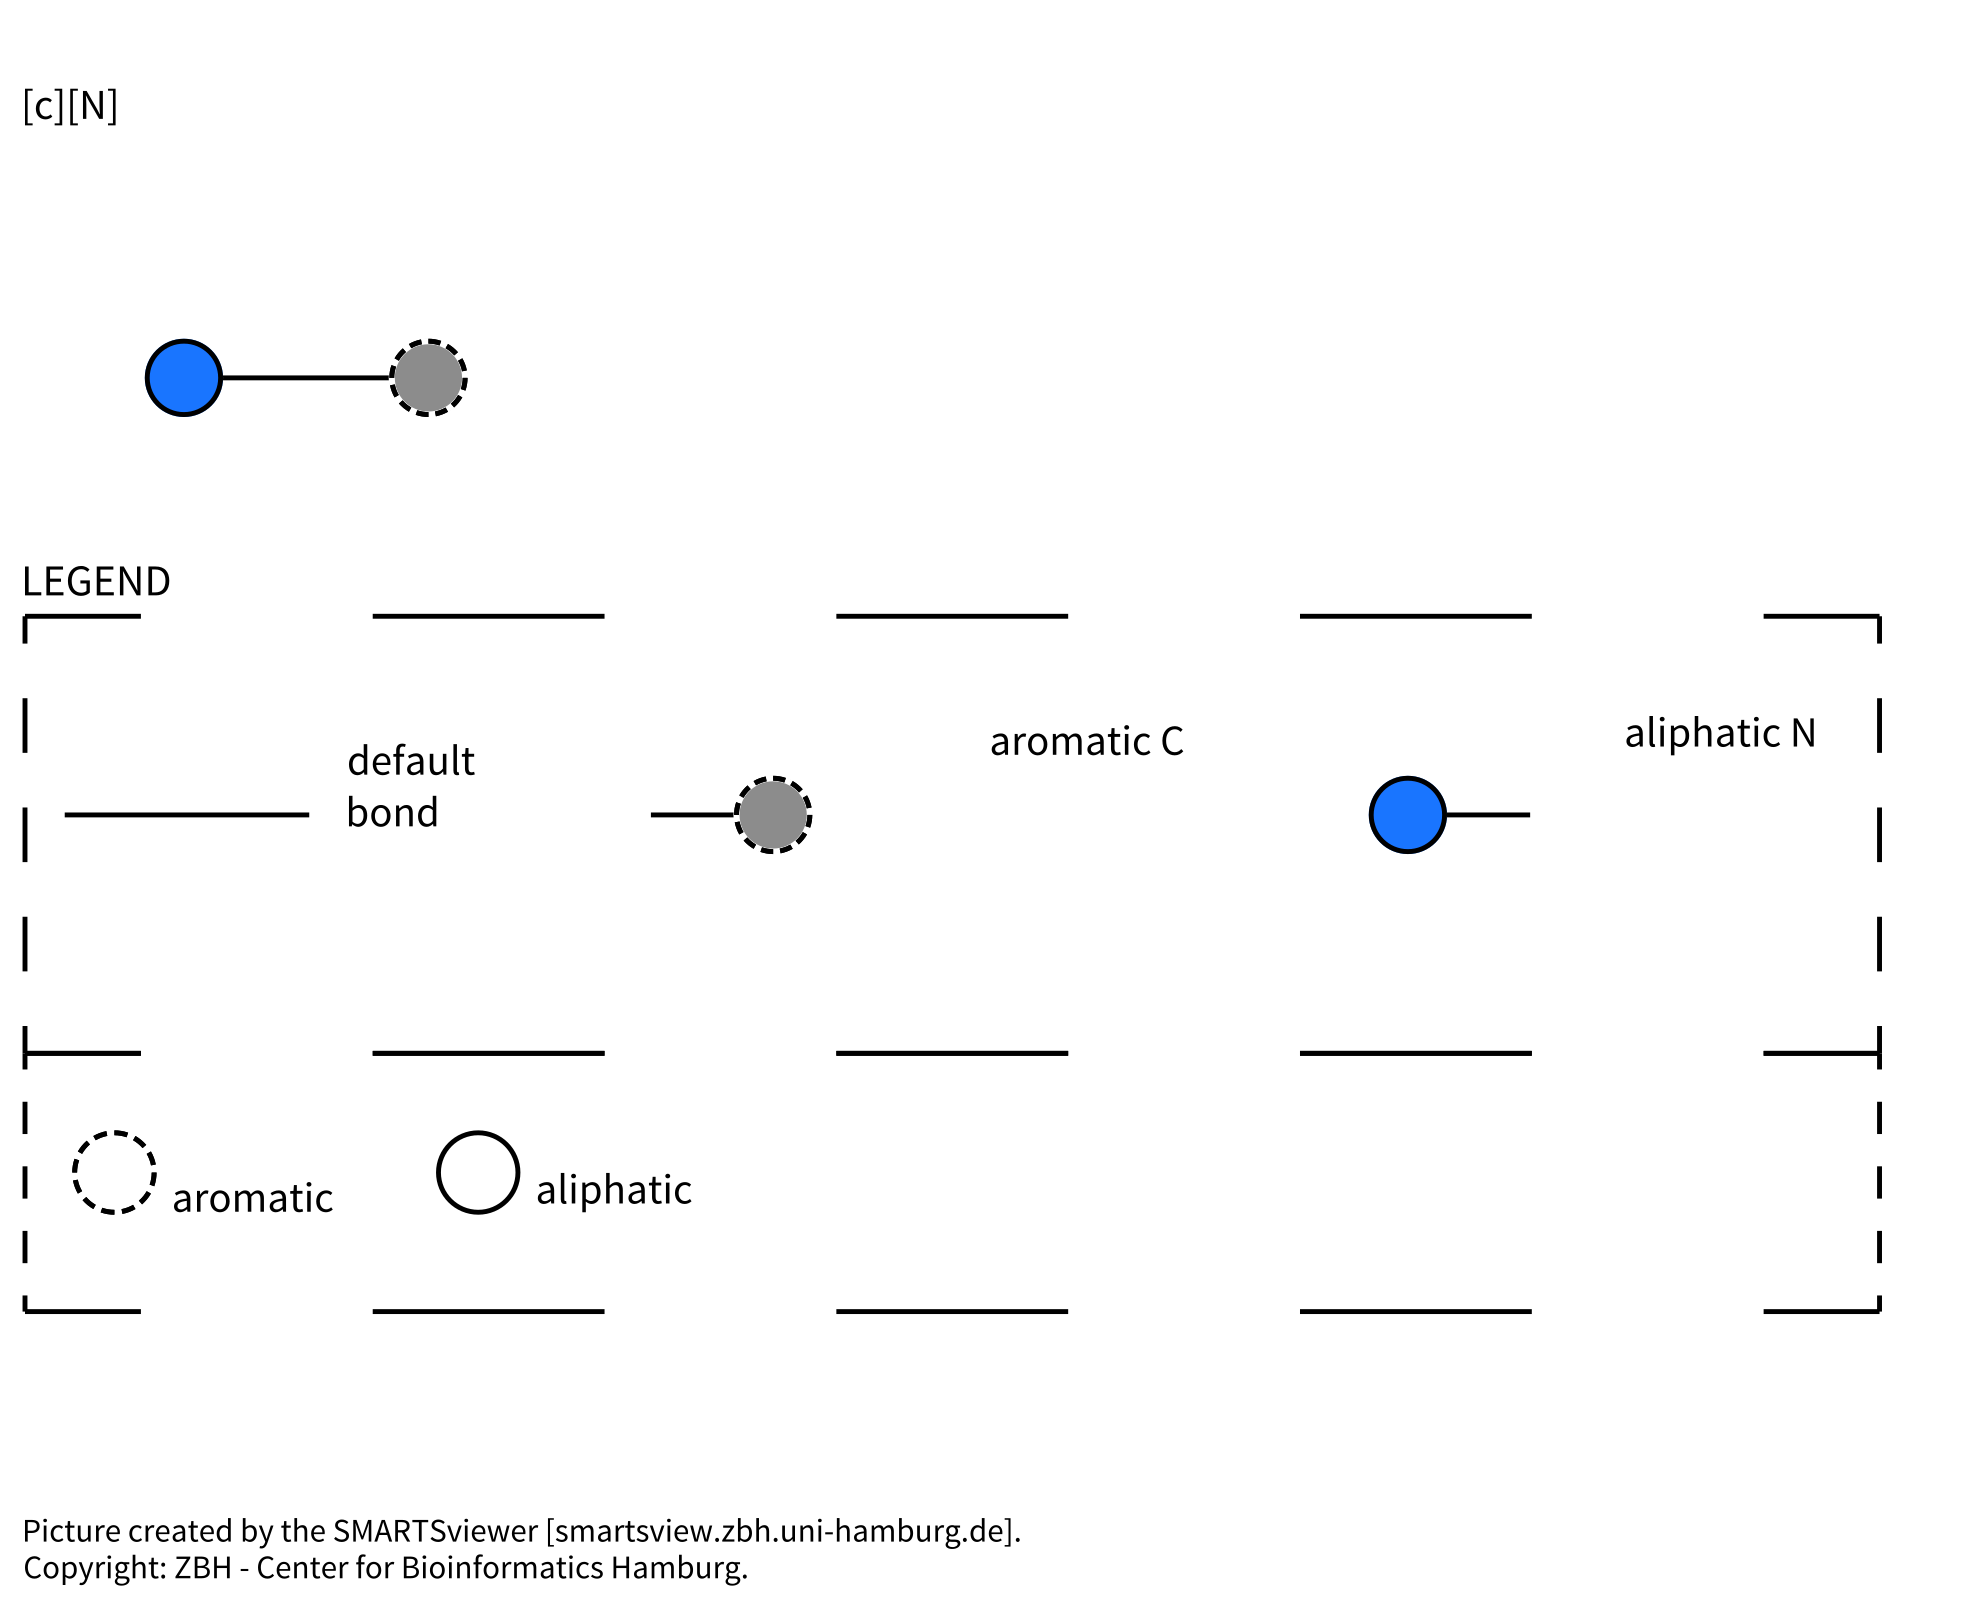

In [17]:
im1 = get_img("smarts=[c][N]")
im1

## Setting up workflow for schrock core

### Julius examle

In [18]:
ts_file = "../catalyst/input_files/ts7_dummy.sdf"
ts_dummy = Chem.SDMolSupplier(ts_file, removeHs=False, sanitize=True)[0]

In [28]:
mol_list = []
with open("../data/ZINC_1000_amines.smi", "r") as file:
    for smiles in file:
        mol_list.append(Chem.MolFromSmiles(smiles))

In [256]:
def connect_cat_2d(mol_with_dummy, cat):
    """Replaces Dummy Atom [*] in Mol with Cat via tertiary Amine, return list of all possible regioisomers"""
    dummy = Chem.MolFromSmiles("*")
    mols = []
    cat = Chem.AddHs(cat)
    AllChem.AssignStereochemistry(cat)
    tert_amines = cat.GetSubstructMatches(Chem.MolFromSmarts("[#7X3;H0;D3;!+1]"))
    if len(tert_amines) == 0:
        raise Exception(
            f"{Chem.MolToSmiles(Chem.RemoveHs(cat))} constains no tertiary amine."
        )
    for amine in tert_amines:
        mol = AllChem.ReplaceSubstructs(
            mol_with_dummy, dummy, cat, replacementConnectionPoint=amine[0]
        )[0]
        quart_amine = mol.GetSubstructMatch(Chem.MolFromSmarts("[#7X4;H0;D4;!+1]"))[0]
        mol.GetAtomWithIdx(quart_amine).SetFormalCharge(1)
        Chem.SanitizeMol(mol)
        mol.RemoveAllConformers()
        mols.append(mol)
    return mols
ts2ds = connect_cat_2d(ts_dummy, mol_list[0])

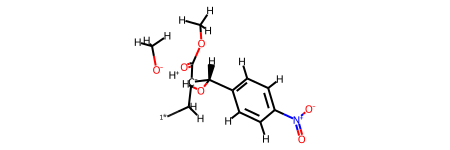

In [257]:
ts_dummy

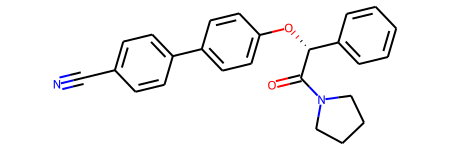

In [258]:
mol_list[0]

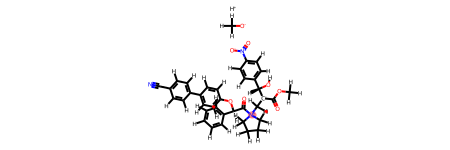

In [259]:
ts2ds[0]

In [4]:
file = "../templates/core_dummy.sdf"
core= Chem.SDMolSupplier(file, removeHs=False, sanitize=False)
core

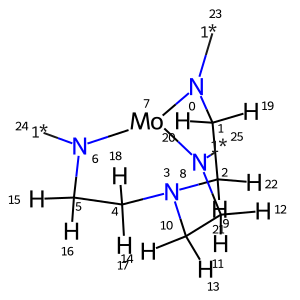

In [5]:
core[0]

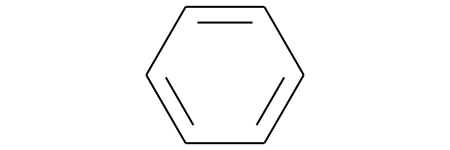

In [77]:
# Assign core and fragment.
benzen_smi = 'C1=CC=CC=C1'
benzen_frag = Chem.MolFromSmiles(benzen_smi)
benzen_frag

(0,)
(1,)
(2,)
(4,)
(12,)
(15,)
(16,)
(21,)
(22,)
(23,)
(25,)


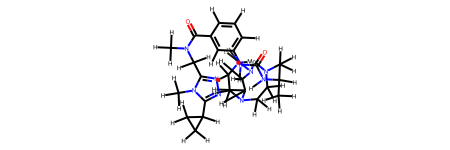

In [141]:
def connect_cat_2d_hydro(mol_with_dummy, cat):
    """Replaces Dummy Atom [*] in Mol with Cat via tertiary Amine, return list of all possible regioisomers"""
    dummy = Chem.MolFromSmiles("*")
    mols = []
    cat = Chem.AddHs(cat)
    AllChem.AssignStereochemistry(cat)
    tert_amines = cat.GetSubstructMatches(Chem.MolFromSmarts("[#7X3;H0;D3;!+1]"))
    if len(tert_amines) == 0:
        raise Exception(
            f"{Chem.MolToSmiles(Chem.RemoveHs(cat))} constains no tertiary amine."
        )
    for amine in tert_amines:
        print(amine)
        mol = AllChem.ReplaceSubstructs(
            mol_with_dummy, dummy, cat, replacementConnectionPoint=amine[0]
        )[0]
        #quart_amine = mol.GetSubstructMatch(Chem.MolFromSmarts("[C]"))[0]
        #print(quart_amine)
        #mol.GetAtomWithIdx(quart_amine).SetFormalCharge(1)
        #Chem.SanitizeMol(mol)
        mol.RemoveAllConformers()
        mols.append(mol)
    return mols
ts2ds = connect_cat_2d_hydro(core[0], mol_list[50])
ts2ds[0]0

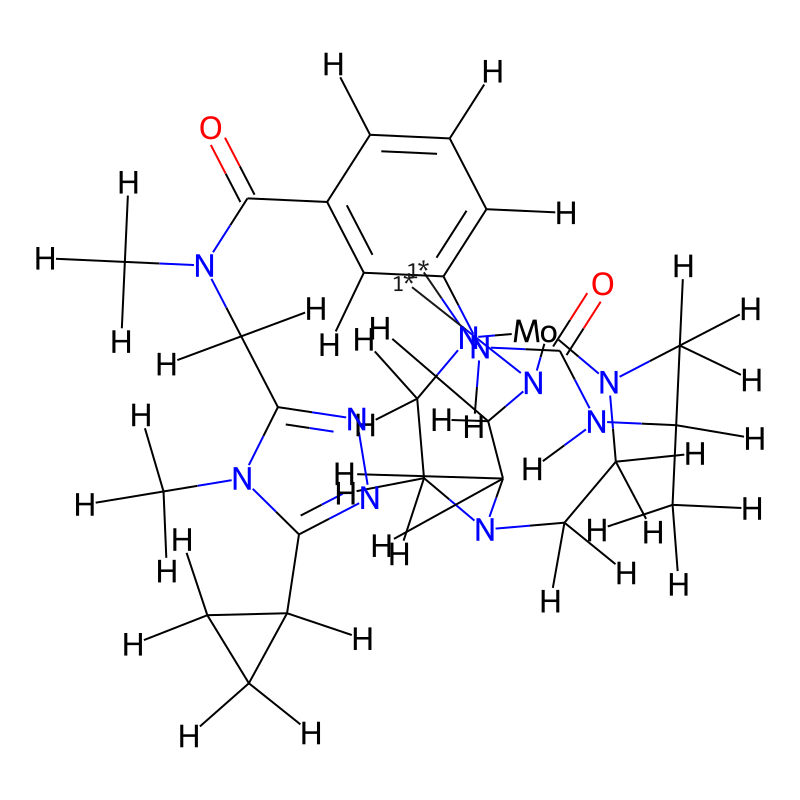

In [136]:
Chem.Draw.MolToImage(ts2ds[0], size=(800, 800))

In [59]:
def draw3d(
    mols,
    width=600,
    height=600,
    Hs=True,
    confId=-1,
    multipleConfs=False,
    atomlabel=False,
):
    try:
        p = py3Dmol.view(width=width, height=height)
        if type(mols) is not list:
            mols = [mols]
        for mol in mols:
            if multipleConfs:
                for conf in mol.GetConformers():
                    mb = Chem.MolToMolBlock(mol, confId=conf.GetId())
                    p.addModel(mb, "sdf")
            else:
                if type(mol) is str:
                    if os.path.splitext(mol)[-1] == ".xyz":
                        xyz_f = open(mol)
                        line = xyz_f.read()
                        xyz_f.close()
                        p.addModel(line, "xyz")
                    # elif os.path.splitext(mol)[-1] == '.out':
                    #     xyz_file = extract_optimized_structure(mol, return_mol=False)
                    #     xyz_f = open(xyz_file)
                    #     line = xyz_f.read()
                    #     xyz_f.close()
                    #     p.addModel(line,'xyz')
                else:
                    mb = Chem.MolToMolBlock(mol, confId=confId)
                    p.addModel(mb, "sdf")
        p.setStyle({"sphere": {"radius": 0.4}, "stick": {}})
        if atomlabel:
            p.addPropertyLabels("index")  # ,{'elem':'H'}
        p.zoomTo()
        p.update()
        # p.show()
    except:
        print("py3Dmol, RDKit, and IPython are required for this feature.")

In [62]:
draw3d(ts2ds[3])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [78]:
dummy = Chem.MolFromSmiles("*")
benzen_frag = Chem.AddHs(benzen_frag)

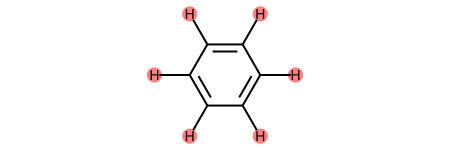

In [81]:
benzen_frag

In [80]:
hydro_location = benzen_frag.GetSubstructMatches(Chem.MolFromSmarts("[H]"))

In [81]:
hydro_location

((6,), (7,), (8,), (9,), (10,), (11,))

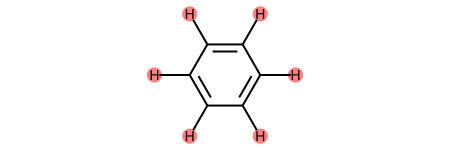

In [82]:
benzen_frag

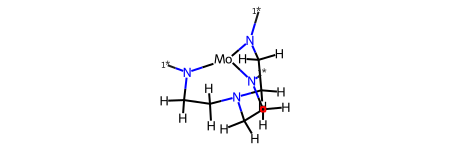

In [83]:
core[0]

RDKit WARNING: [09:24:30] WARNING: not removing hydrogen atom without neighbors
[09:24:30] WARNING: not removing hydrogen atom without neighbors


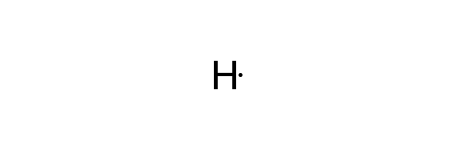

In [97]:
test_frag=Chem.MolFromSmiles("[H]")
test_frag

In [88]:
#AllChem.AssignStereochemistry(benzen_frag)
mol = AllChem.ReplaceSubstructs(
    core[0], dummy, benzen_frag, replacementConnectionPoint=hydro_location[0][0]
)

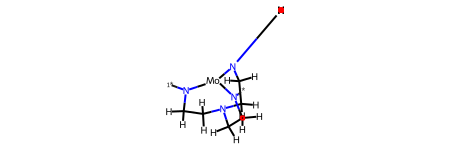

In [98]:
mol[0]

In [103]:
coordMap = {}
coreConf = core[0].GetConformer(-1)
for i, idxI in enumerate(match):
    corePtI = coreConf.GetAtomPosition(i)
    coordMap[idxI] = corePtI

NameError: name 'match' is not defined

In [100]:
cids = AllChem.EmbedMultipleConfs(
        mol=mol[0],
        numConfs=1,
        coordMap=coordMap,
        randomSeed=randomseed,
        numThreads=numThreads,
        pruneRmsThresh=pruneRmsThresh,
        useRandomCoords=True,
    )

NameError: name 'mol_bonded' is not defined

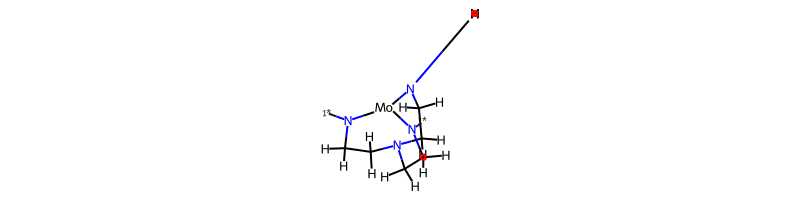

In [129]:
Chem.Draw.MolToImage(mol, size=(800, 200))

In [93]:
repl = Chem.MolFromSmiles('C1=CC=CC=C1')

#patt = Chem.MolFromSmarts('[#1;$([#1][!#6])]')      # hydrogen not on carbon
patt = Chem.MolFromSmarts('[#1;$([#1][#7,#16])]')   # hydrogen on nitrogen or sulfur

mol = core[0]
rms = Chem.ReplaceSubstructs(mol, patt, repl, replaceAll=True)

newMol = Chem.RemoveHs(rms[0])

In [94]:
core[0].HasSubstructMatch(patt)

False

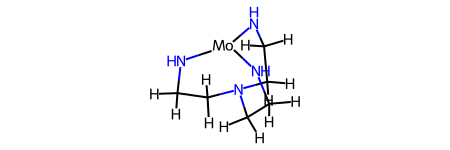

In [77]:
core[0]

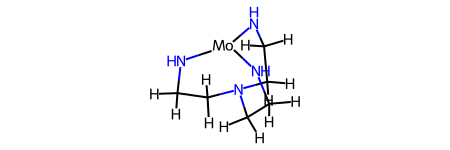

In [78]:
rms[0]

repl = Chem.MolFromSmiles('C')

patt = Chem.MolFromSmarts('[#1;$([#1][!#6])]')      # hydrogen not on carbon
#patt = Chem.MolFromSmarts('[#1;$([#1][#7,#16])]')   # hydrogen on nitrogen or sulfur

mol = Chem.AddHs(Chem.MolFromSmiles('C(CN)SS'))

rms = Chem.ReplaceSubstructs(mol, patt, repl, replaceAll=True)

newMol = Chem.RemoveHs(rms[0])

### Make benzene cycle

In [31]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    [#7X3;H0;D3;!+1]
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    if surface:
        assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [18]:
def mol_from_xyz(xyz_file,charge):
    atoms, _, xyz_coordinates = read_xyz_file(xyz_file)
    print(atoms,xyz_coordinates,charge)
    mol = xyz2mol(atoms, xyz_coordinates, charge)
    return mol

### Testing smiles for cycle

In [32]:
mol = Chem.MolFromSmiles("N=[N-]")

In [36]:
MolTo3DView(mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Try to cut out the tertiary amine and put remaining ligand on

In [3]:
def connect_cat_2d_hydro(mol_with_dummy, cat):
    """Replaces Dummy Atom [*] in Mol with Cat via tertiary Amine, return list of all possible regioisomers"""
    dummy = Chem.MolFromSmiles("*")
    mols = []
    cat = Chem.AddHs(cat)
    AllChem.AssignStereochemistry(cat)
    tert_amines = cat.GetSubstructMatches(Chem.MolFromSmarts("[#7X3;H0;D3;!+1]"))
    if len(tert_amines) == 0:
        raise Exception(
            f"{Chem.MolToSmiles(Chem.RemoveHs(cat))} constains no tertiary amine."
        )
    for amine in tert_amines:
        print(amine)
        
        # Get the neigbouring bonds to the amine
        
        
        mol = AllChem.ReplaceSubstructs(
            mol_with_dummy, dummy, cat, replacementConnectionPoint=amine[0]
        )[0]
        quart_amine = mol.GetSubstructMatch(Chem.MolFromSmarts("[C]"))[0]
        #print(quart_amine)
        mol.GetAtomWithIdx(quart_amine).SetFormalCharge(1)
        #Chem.SanitizeMol(mol)
        mol.RemoveAllConformers()
        mols.append(mol)
    return mols
ts2ds = connect_cat_2d_hydro(core[0], mol_list[50])
ts2ds[0]

NameError: name 'core' is not defined

In [15]:
mol_with_dummy = core[0]
cat = mol_list[50]
dummy = Chem.MolFromSmiles("*")
mols = []
#cat = Chem.AddHs(cat)
AllChem.AssignStereochemistry(cat)
tert_amines = cat.GetSubstructMatches(Chem.MolFromSmarts("[#7X3;H0;D3;!+1]"))
if len(tert_amines) == 0:
    raise Exception(
        f"{Chem.MolToSmiles(Chem.RemoveHs(cat))} constains no tertiary amine."
    )
#for amine in tert_amines:
amine = tert_amines[0]

# Get the neigbouring bonds to the amine
atom = cat.GetAtomWithIdx(amine[0])
indices = [(amine[0],x.GetIdx()) for x in atom.GetNeighbors()]
bonds = []
for atoms in indices:
    bonds.append(cat.GetBondBetweenAtoms(atoms[0], atoms[1]).GetIdx())
frag = Chem.FragmentOnBonds(cat, bonds,addDummies=True,dummyLabels=[(1, 1),(1, 1),(1, 1)])
frags = Chem.GetMolFrags(frag, asMols=True, sanitizeFrags=False)

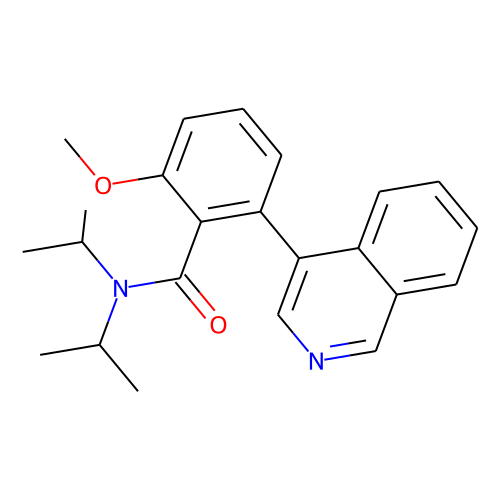

In [20]:
Draw.MolToImage(cat,size=(500,500))

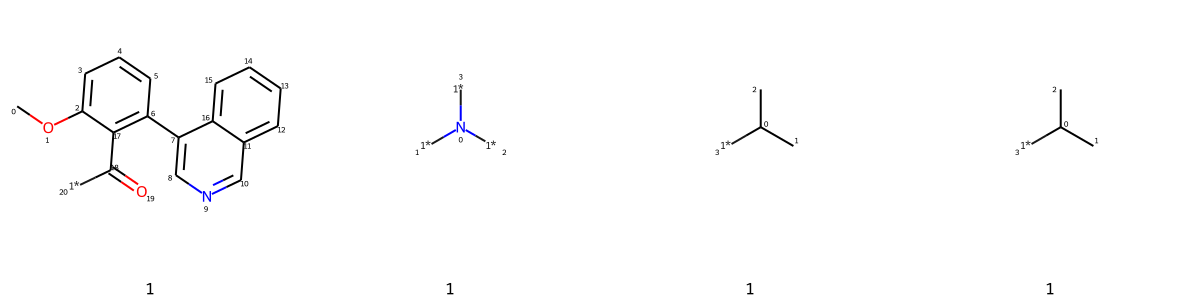

In [26]:
Draw.MolsToGridImage(frags,molsPerRow=4,maxMols=10,legends=['1' for x in range(100,120)], subImgSize=(300,300))

In [500]:
# Substructure match to find the fragment with the Mo-core
smart = "[1*][N]"

# Initialize pattern
patt = Chem.MolFromSmarts(smart)

# Get list of ligands
ligands = [struct for struct in frags if not struct.HasSubstructMatch(patt)]

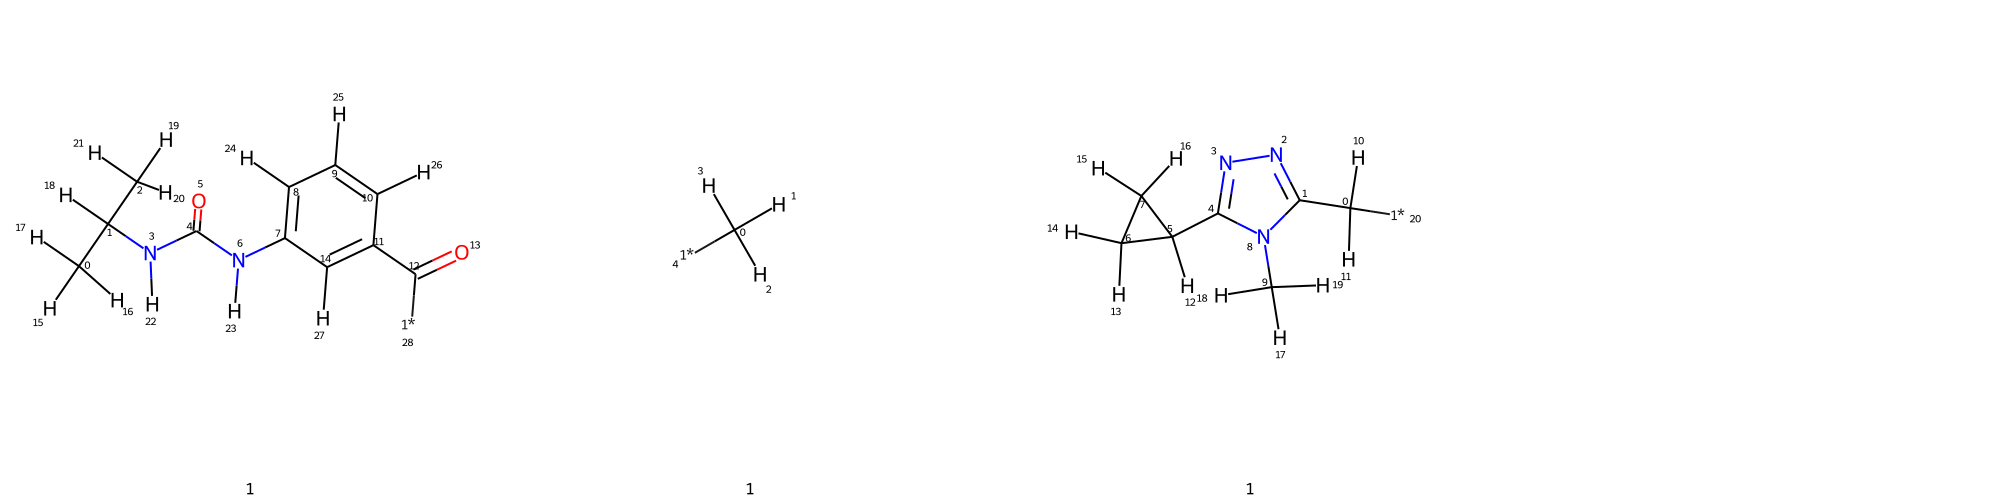

In [501]:
Draw.MolsToGridImage(ligands,molsPerRow=4,maxMols=10,legends=['1' for x in range(100,120)], subImgSize=(500,500))

In [502]:
for i,ligand in enumerate(ligands):
    
    # Now we need to get the indice of the atom the dummy is bound to 
    dummy_idx = ligand.GetSubstructMatch(Chem.MolFromSmiles("*"))
    neigh = ligand.GetAtomWithIdx(dummy_idx[0])
    bond = [(dummy_idx[0],x.GetIdx()) for x in neigh.GetNeighbors()]
    print(bond)
    new_bond = ligand.GetBondBetweenAtoms(bond[0][0], bond[0][1]).GetIdx()
    frag = Chem.FragmentOnBonds(ligand, [new_bond],addDummies=False)
    frags = Chem.GetMolFrags(frag, asMols=True, sanitizeFrags=False)
    
    mol = AllChem.ReplaceSubstructs(
            mol_with_dummy, dummy, frags[0], replacementConnectionPoint=bond[0][1] 
        )[0]
    quart_amine = mol.GetSubstructMatch(Chem.MolFromSmarts("[C]"))[0]
    #print(quart_amine)
    #mol.GetAtomWithIdx(quart_amine).SetFormalCharge(1)
    Chem.SanitizeMol(mol)
    mol.RemoveAllConformers()
    mols.append(mol)

[(28, 12)]
[(4, 0)]
[(20, 0)]


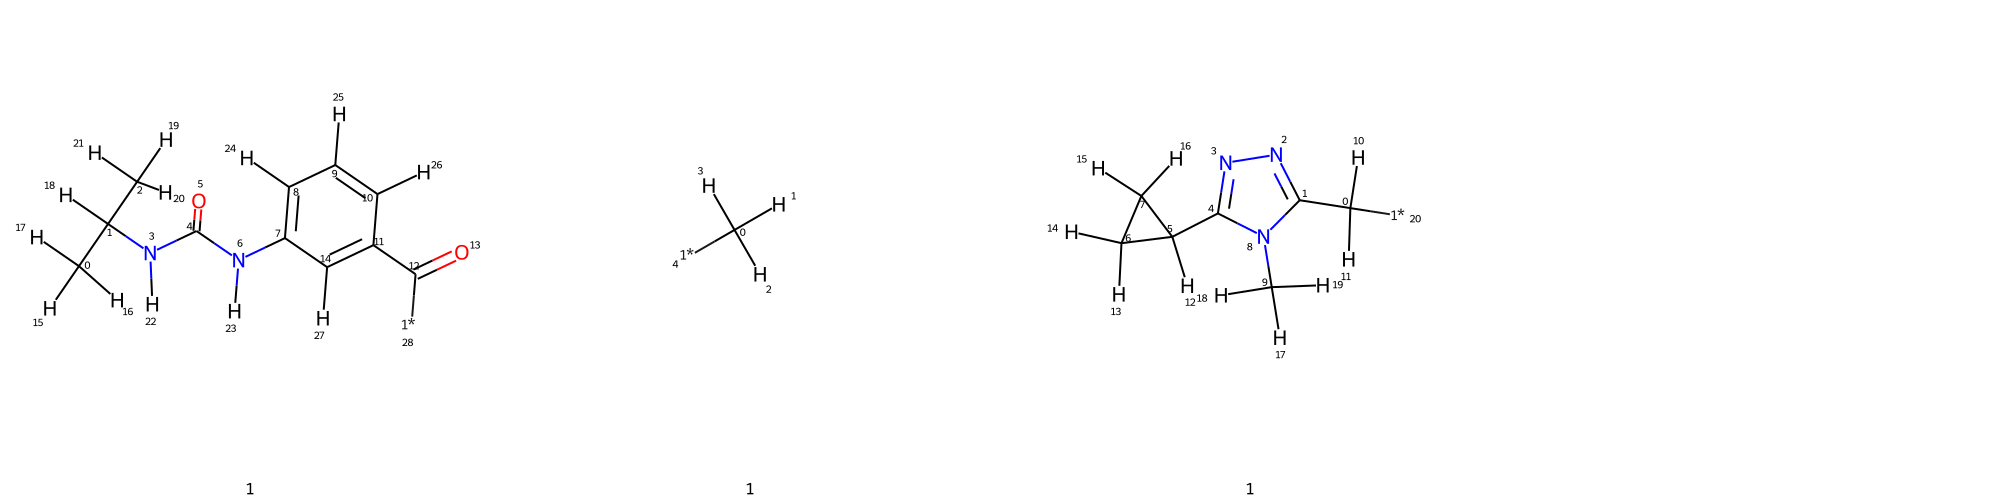

In [503]:
Draw.MolsToGridImage(ligands,molsPerRow=4,maxMols=10,legends=['1' for x in range(100,120)], subImgSize=(500,500))

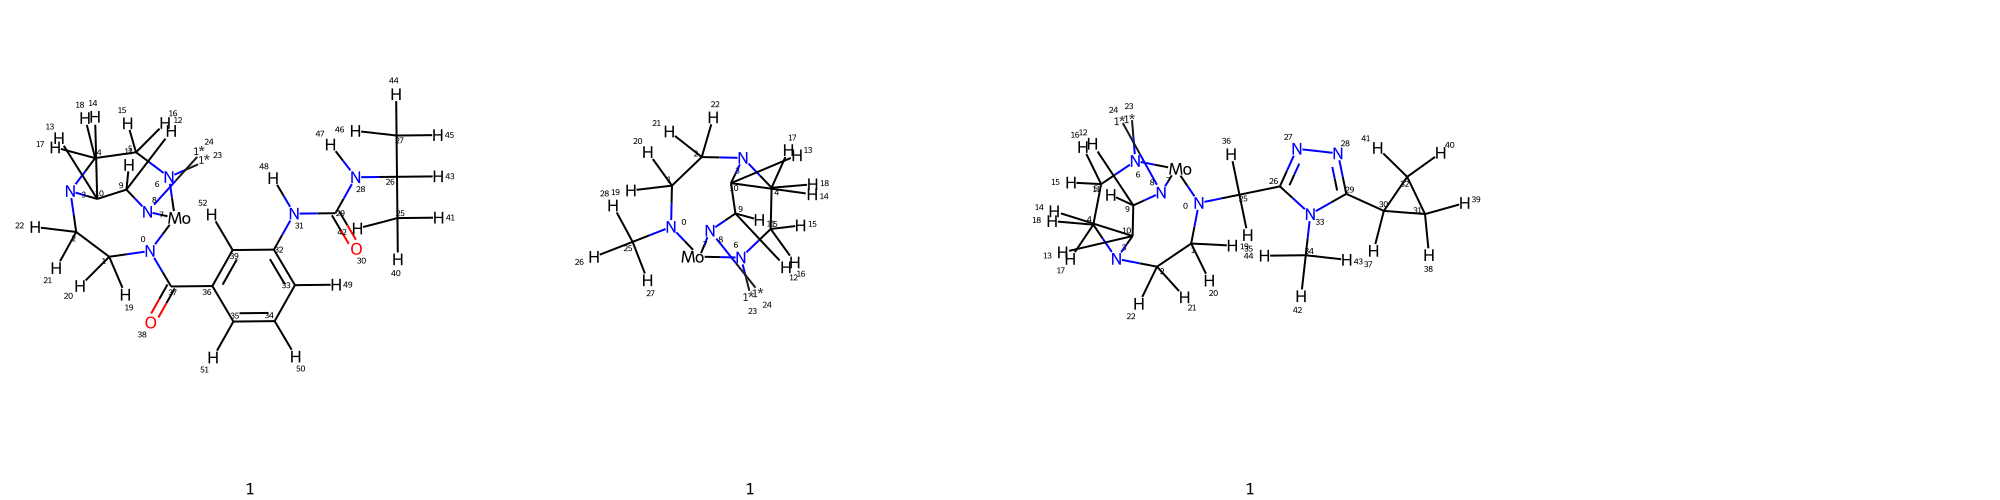

In [504]:
Draw.MolsToGridImage(mols,molsPerRow=4,maxMols=10,legends=['1' for x in range(100,120)], subImgSize=(500,500))